In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Generalized Function to Load Data

In [2]:
def load_data(folder_path, pattern_prefix):
    """
    Load data from Excel files with flexible naming pattern
    
    Args:
        folder_path: Path to directory containing Excel files
        pattern_prefix: The middle part of the filename (e.g., "Location" or "Scenarios")
                       Files should be named like f"SA_{pattern_prefix}_*.xlsx"
    
    Returns:
        Nested dictionary: {name: {sheet: DataFrame}}
    """
    # Verify the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The directory {folder_path} does not exist")
    
    # Create regex pattern to extract names
    pattern = re.compile(fr'SA_{pattern_prefix}_(.*?)\.xlsx')
    
    # Get all names from filenames
    names = []
    for f in os.listdir(folder_path):
        match = pattern.match(f)
        if match:
            names.append(match.group(1))
    
    # Initialize nested dictionary
    data_dict = {name: {} for name in names}
    
    # Read each file and its sheets
    for name in data_dict.keys():
        filename = f"SA_{pattern_prefix}_{name}.xlsx"
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read all sheets from the Excel file
            sheets = pd.read_excel(file_path, sheet_name=None)
            
            # Store each sheet (Fold_1 to Fold_5) in the dictionary
            for sheet_num in range(1, 6):
                sheet_name = f"Fold_{sheet_num}"
                if sheet_name in sheets:
                    data_dict[name][sheet_name] = sheets[sheet_name]
                else:
                    print(f"Warning: Sheet {sheet_name} not found in {filename}")
                    
        except FileNotFoundError:
            print(f"Warning: File {filename} not found in {folder_path}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    return data_dict

## Generalized Function to Stacked Algorithm Performance Plot

In [9]:
def prepare_stacked_data(data, fields):
    stacked_data = []
    
    for field, folds in data.items():
        for algorithm in ['LP', 'SO', 'RO']:
            capex_sum = opex_hvac_sum = opex_c_sum = 0
            count = 0
            
            for fold, df in folds.items():
                alg_df = df[df['Algorithm'] == algorithm]
                if not alg_df.empty:
                    capex_sum += alg_df['Training Capital Cost'].mean()
                    opex_hvac_sum += alg_df['Testing HVAC Cost'].mean()
                    opex_c_sum += alg_df['Testing Critical Load Cost'].mean()
                    count += 1
            
            if count > 0:
                stacked_data.append({
                    fields: field,
                    'Algorithm': algorithm,
                    'CaPEX': capex_sum / count,
                    'OPEX HVAC': opex_hvac_sum / count,
                    'OPEX C': opex_c_sum / count,
                    'Total': (capex_sum + opex_hvac_sum + opex_c_sum) / count
                })
    
    return pd.DataFrame(stacked_data)

def plot_grouped_stacked_bars(data, SA_name, plot_name):
    # Prepare data
    stacked_df = prepare_stacked_data(data, SA_name)
    locations = stacked_df[SA_name].unique()
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#0072B2', '#D55E00', '#009E73']  # Colorblind-friendly

    # Set global style
    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        'font.size': 16,
        'axes.labelsize': 18,
        'axes.titlesize': 20,
        'legend.fontsize': 16,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'axes.linewidth': 1.5,
        'figure.dpi': 300
    })

    fig, axes = plt.subplots(1, len(locations), figsize=(7*len(locations), 7), sharex=False, sharey=False)
    if len(locations) == 1:
        axes = [axes]
    plt.subplots_adjust(wspace=0.3)

    bar_width = 0.6
    x_pos = np.arange(len(algorithms))

    for idx, (ax, loc) in enumerate(zip(axes, locations)):
        loc_df = stacked_df[stacked_df[SA_name] == loc]
        bottom = np.zeros(len(algorithms))
        for i, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [loc_df[loc_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            bars = ax.bar(x_pos, values, bar_width, bottom=bottom, color=colors[i], edgecolor='black', linewidth=1.5)
            bottom += np.array(values)
        ax.set_title(loc, pad=15, fontsize=20, fontweight='bold')
        ax.set_ylabel('Cost ($)', fontsize=18)
        ax.set_ylim(0, max(bottom)*1.15)
        ax.grid(axis='y', linestyle='--', alpha=0.7, linewidth=1)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(algorithms, fontweight='bold')
        sns.despine(ax=ax)
        if idx == 0:
            ax.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'], loc='upper left', fontsize=16, frameon=False)
    plt.suptitle(f'Testing Stage Performance of Algorithms with different {plot_name}', y=1.02, fontsize=24, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Generalized Function to do Capacity Box Plot

In [14]:
def capacity_box_plot(location_data, SA_name, plot_name):
    def prepare_plotting_data(data_dict):
        plot_data = []
        for category, folds in data_dict.items():
            for fold_num, df in folds.items():
                temp_df = df.copy()
                temp_df['Category'] = category
                temp_df['Fold'] = fold_num
                plot_data.append(temp_df)
        return pd.concat(plot_data, ignore_index=True)

    plot_df = prepare_plotting_data(location_data)
    categories = sorted(plot_df['Category'].unique())

    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        'font.size': 16,
        'axes.labelsize': 18,
        'axes.titlesize': 20,
        'legend.fontsize': 16,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'axes.linewidth': 1.5,
        'figure.dpi': 300
    })

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    plt.suptitle(f'Capacity Sizings across {plot_name} and Folds', fontsize=24, y=1.02, fontweight='bold')
    boxprops = dict(linewidth=2)
    whiskerprops = dict(linewidth=2)
    capprops = dict(linewidth=2)
    medianprops = dict(linewidth=2, color='black')

    for ax, y, title in zip(axs.flat,
                            ['PV_Size', 'Battery_Size', 'PCM_Heating_Size', 'PCM_Cooling_Size'],
                            ['PV Size Distribution', 'Battery Size Distribution', 'PCM Heating Size Distribution', 'PCM Cooling Size Distribution']):
        sns.boxplot(x='Category', y=y, hue='Algorithm', data=plot_df, order=categories,
                    hue_order=['LP', 'SO', 'RO'], ax=ax, boxprops=boxprops,
                    whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)
        ax.set_title(title, fontsize=20, fontweight='bold')
        ax.set_xlabel(SA_name, fontsize=18)
        ax.set_ylabel(y.replace('_', ' '), fontsize=18)
        ax.legend(title='Algorithm', frameon=False)
        sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()

## Locations

In [15]:
SA_name = 'Locations'

# Example usage for Locations:
location_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars(location_data, SA_name, "Locations")

# For location analysis
capacity_box_plot(location_data, SA_name, "Locations")

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [13]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Scenarios

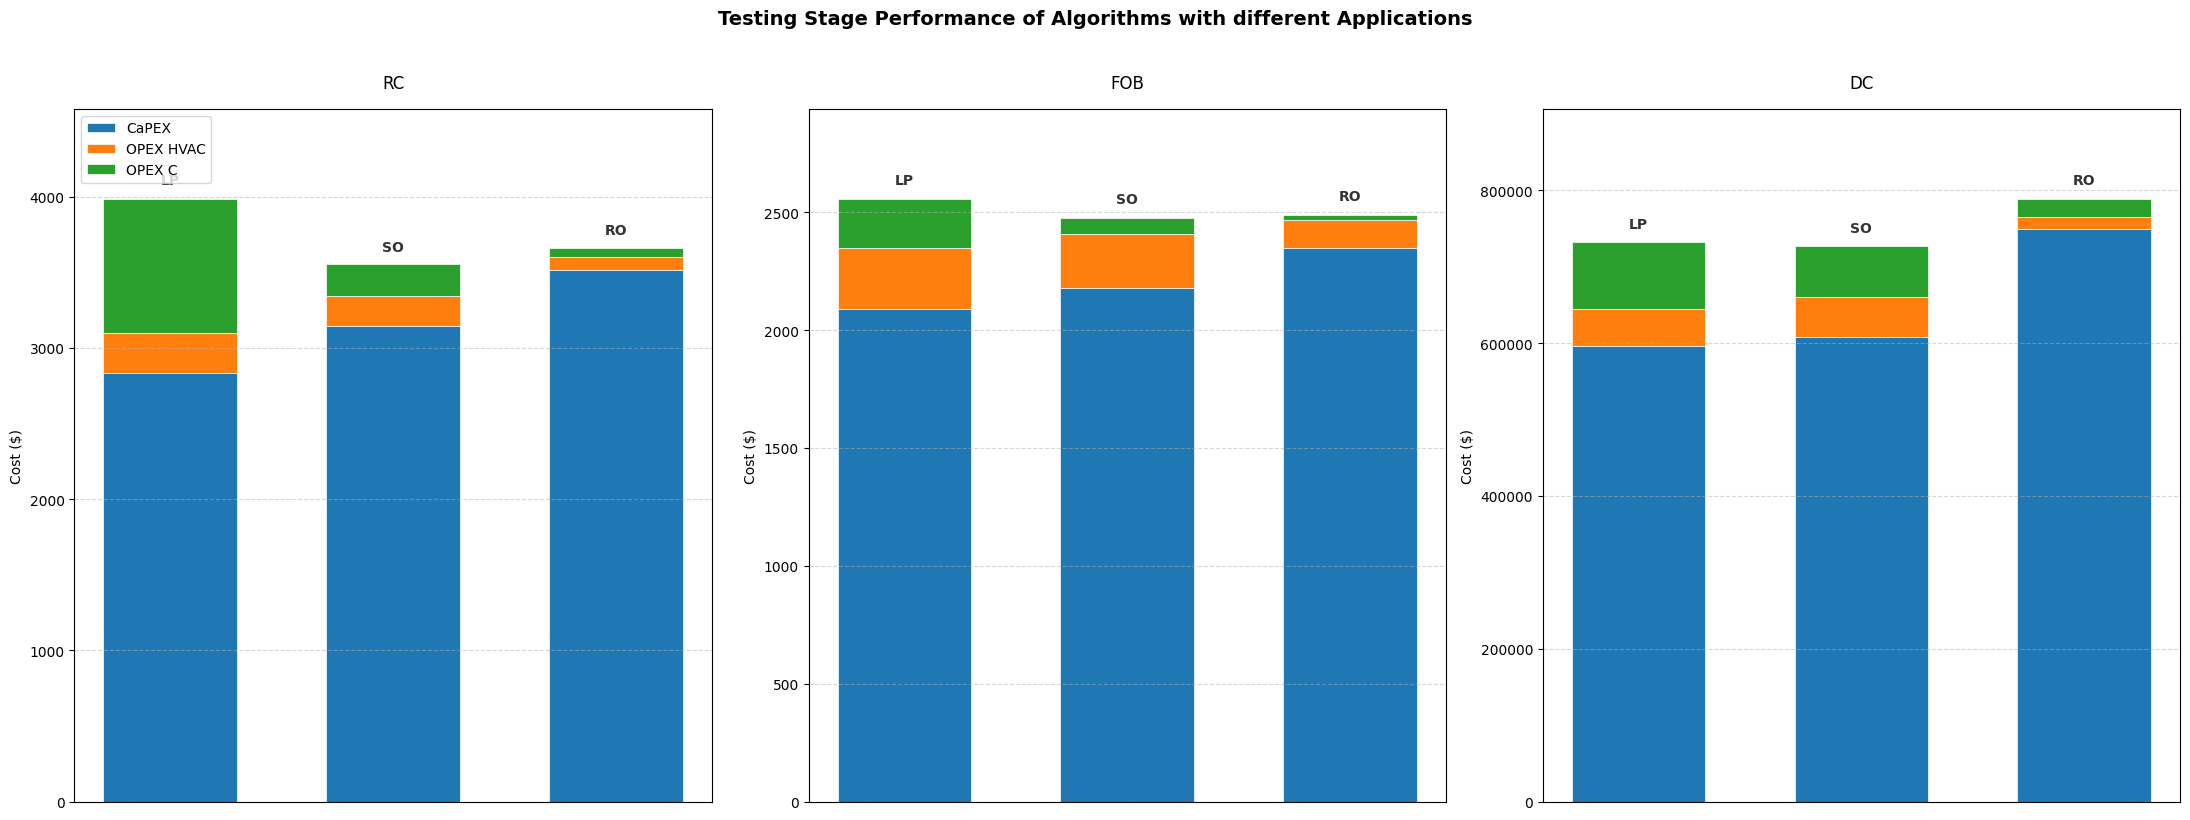

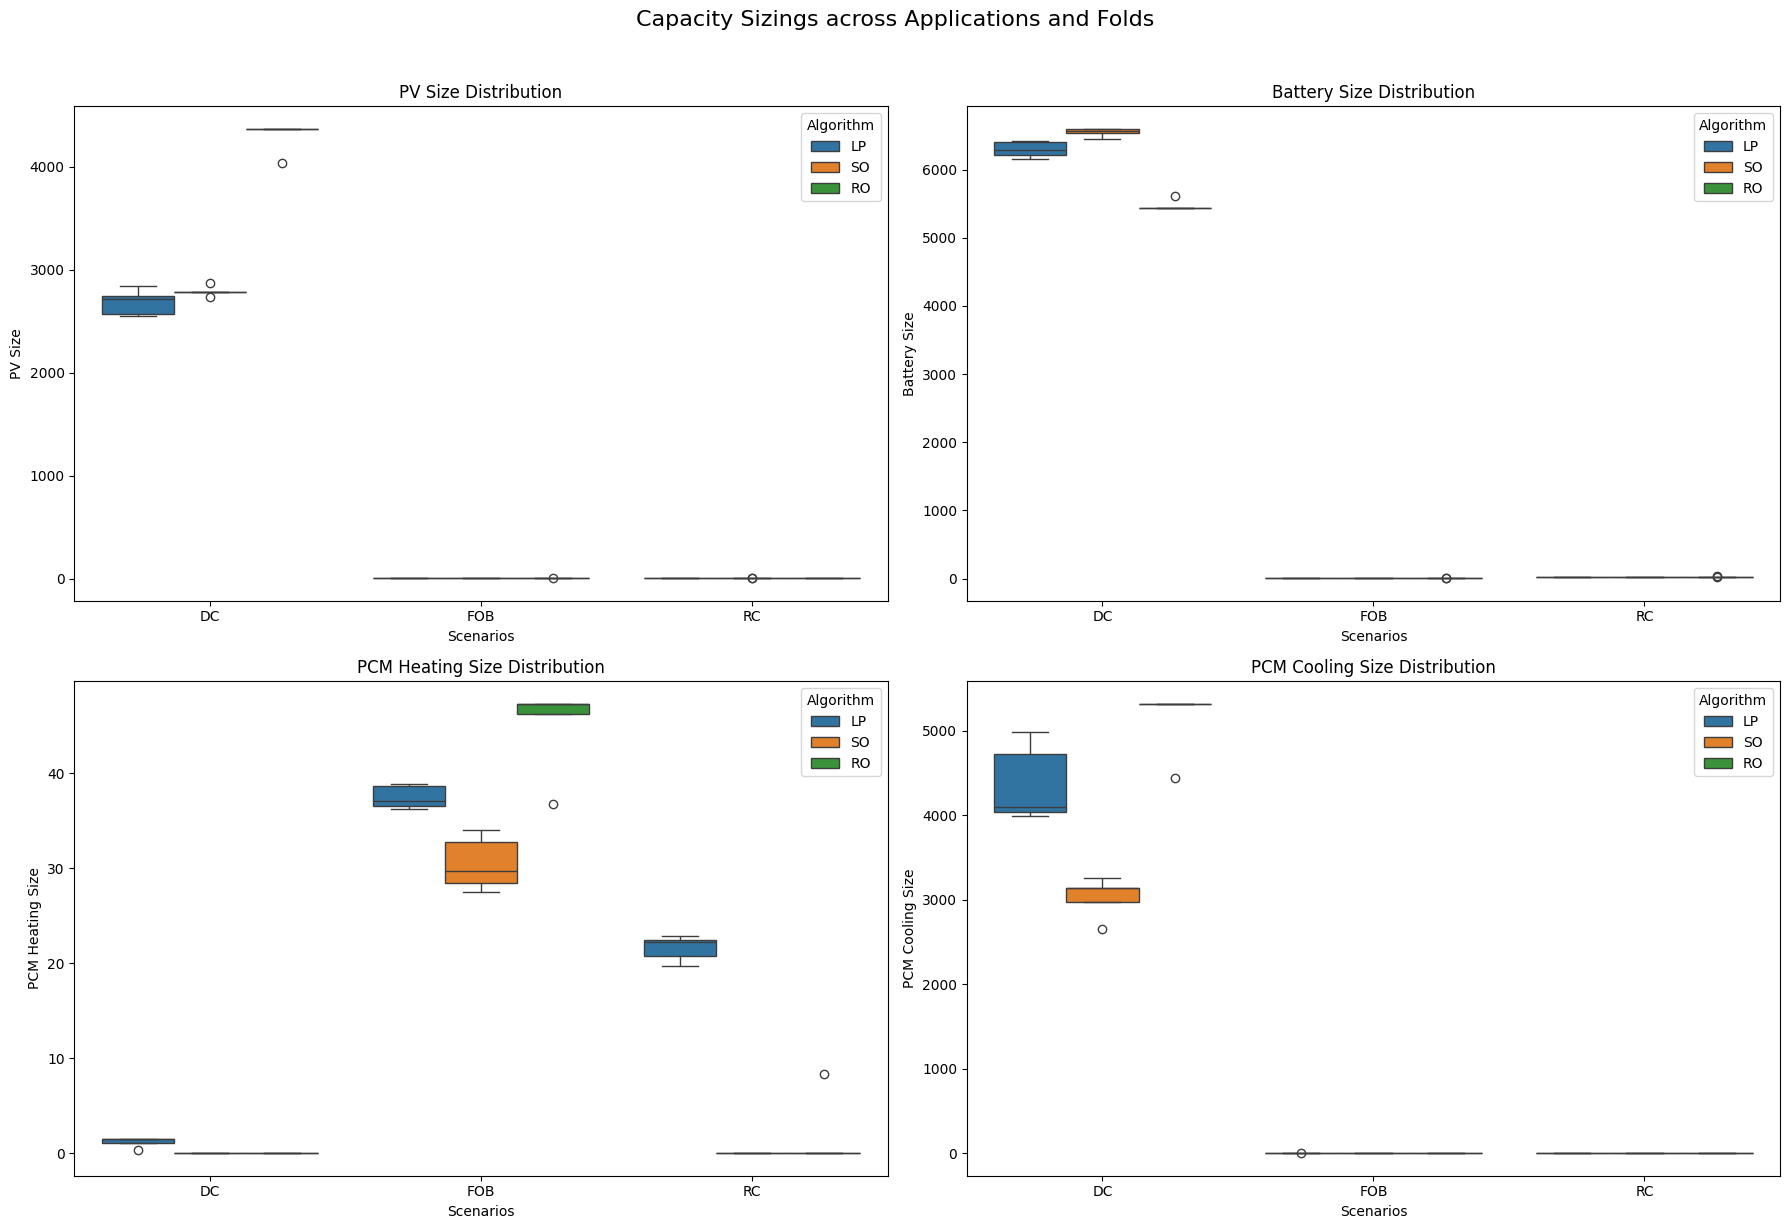

In [6]:
SA_name = 'Scenarios'

# Example usage for Locations:
scenario_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars(scenario_data, SA_name, "Applications")

# For location analysis
capacity_box_plot(scenario_data, SA_name, "Applications")

## Capacity Costs

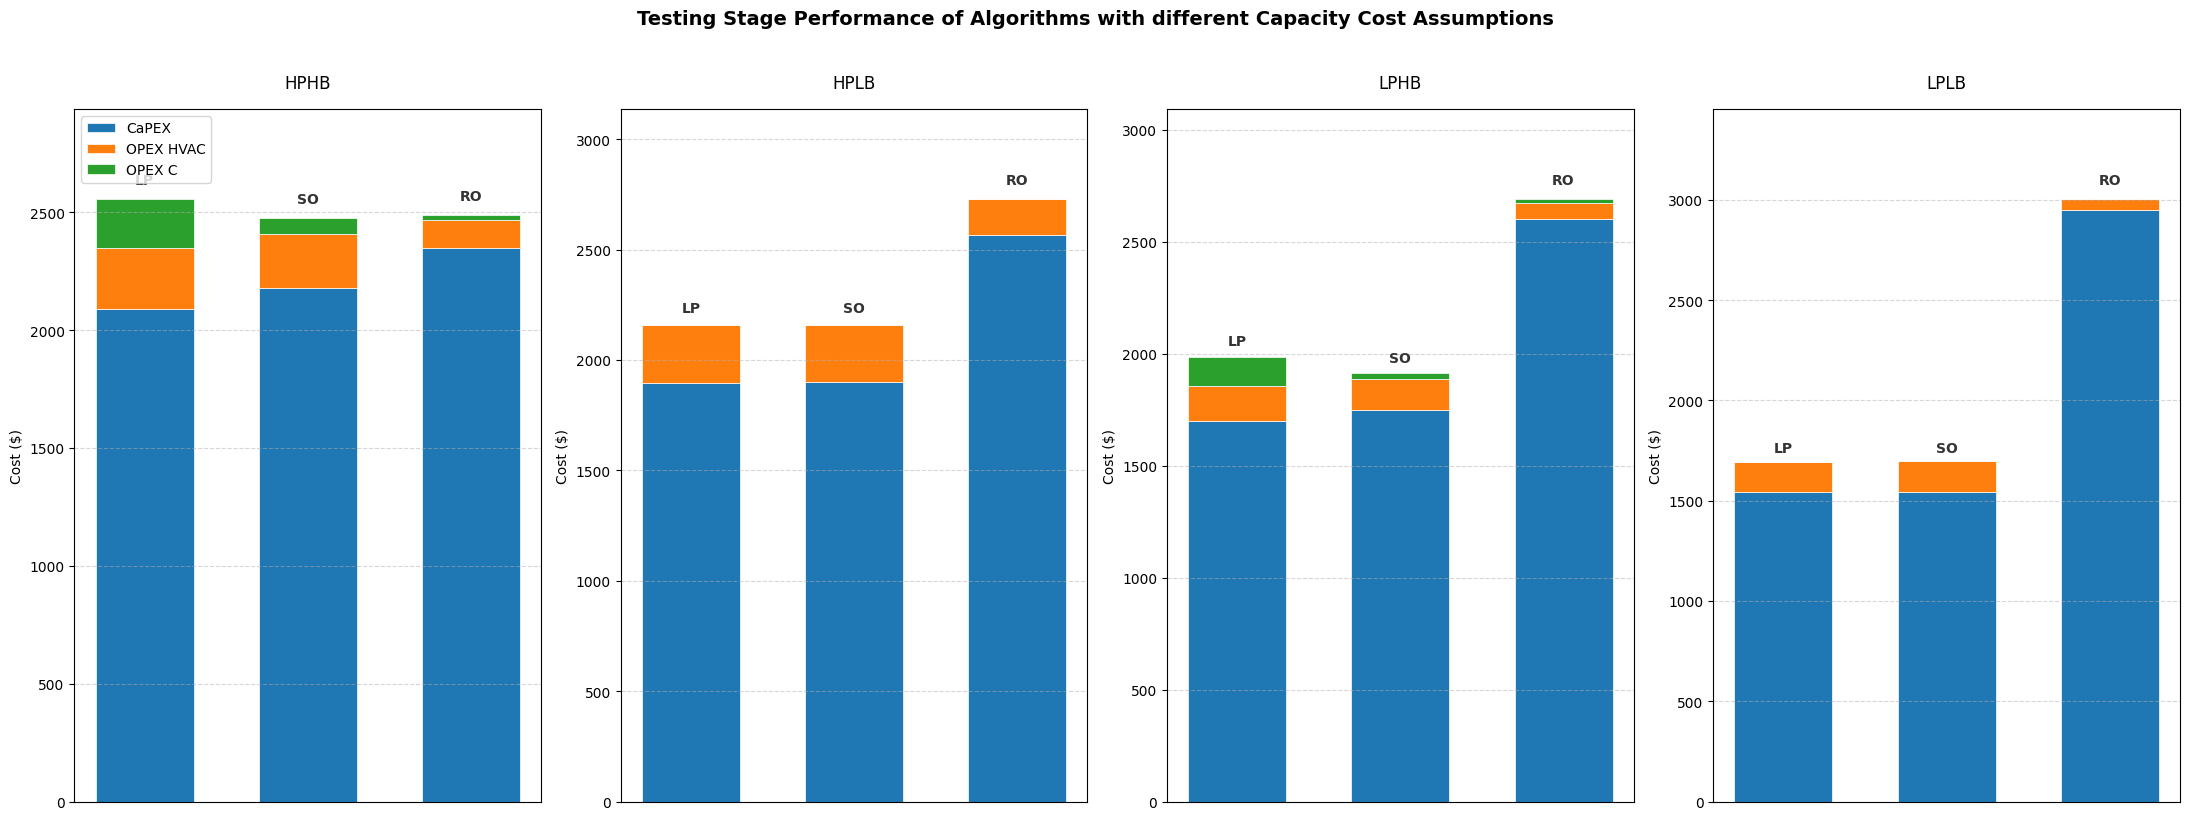

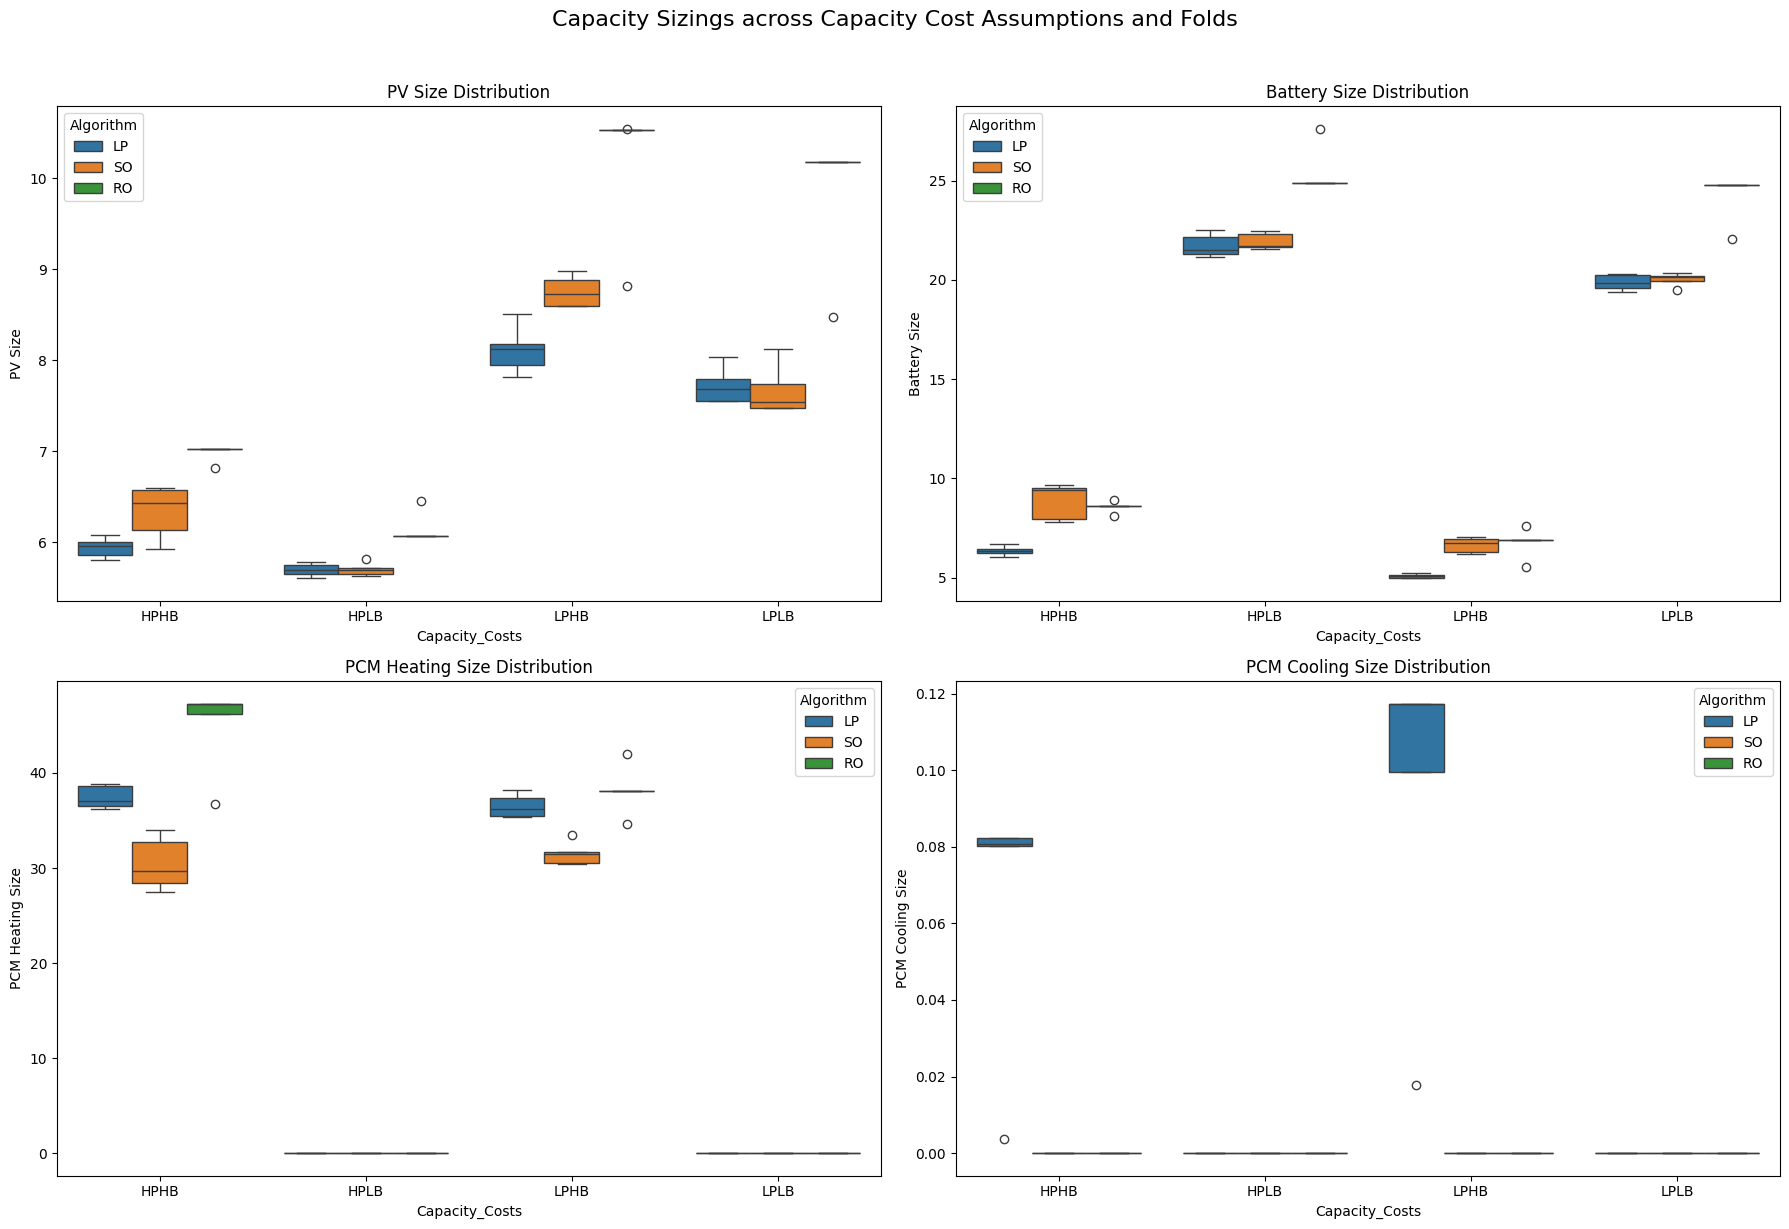

In [7]:
SA_name = 'Capacity_Costs'

# Example usage for Locations:
cap_cost_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars(cap_cost_data, SA_name, "Capacity Cost Assumptions")

# For location analysis
capacity_box_plot(cap_cost_data, SA_name, "Capacity Cost Assumptions")

/var/folders/ll/cq_mlqg56938kmwh8dys19n80000gn/T/ipykernel_22419/305444061.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


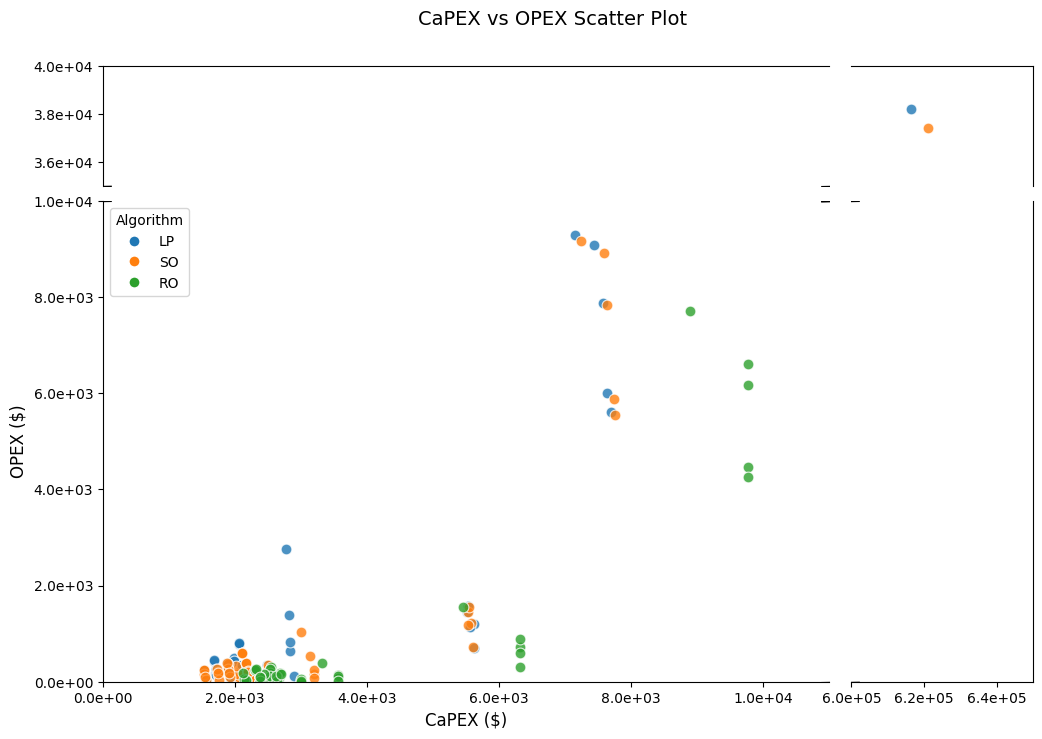

In [8]:
from matplotlib.patches import Rectangle

def prepare_scatter_data(data_dict, category_name):
    """Convert nested dictionary to DataFrame with category label"""
    scatter_data = []
    
    for sub_category, folds in data_dict.items():
        for fold_num, df in folds.items():
            for _, row in df.iterrows():
                scatter_data.append({
                    'Category': category_name,
                    'SubCategory': sub_category,
                    'Fold': fold_num,
                    'Algorithm': row['Algorithm'],
                    'CaPEX': row['Training Capital Cost'],
                    'OPEX': row['Testing HVAC Cost'] + row['Testing Critical Load Cost']
                })
    return pd.DataFrame(scatter_data)

def create_dual_axis_break_plot(all_data):
    # Create figure with custom gridspec
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                        wspace=0.05, hspace=0.05)

    # Create axes
    ax_main = fig.add_subplot(gs[1, 0])  # Main plot area
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)  # High OPEX
    ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)  # High CaPEX
    ax_corner = fig.add_subplot(gs[0, 1])  # High-High quadrant

    # Define colors and style
    colors = {'LP': '#1f77b4', 'SO': '#ff7f0e', 'RO': '#2ca02c'}
    marker_size = 60
    alpha = 0.8

    # Plot data in all relevant areas
    for algorithm, color in colors.items():
        alg_data = all_data[all_data['Algorithm'] == algorithm]
        
        # Main plot (low CaPEX, low OPEX)
        ax_main.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                       c=color, s=marker_size, alpha=alpha, label=algorithm,
                       edgecolor='w', linewidth=0.8)
        
        # High CaPEX area
        ax_right.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                        c=color, s=marker_size, alpha=alpha,
                        edgecolor='w', linewidth=0.8)
        
        # High OPEX area
        ax_top.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                      c=color, s=marker_size, alpha=alpha,
                      edgecolor='w', linewidth=0.8)
        
        # High-High area
        ax_corner.scatter(alg_data['CaPEX'], alg_data['OPEX'],
                         c=color, s=marker_size, alpha=alpha,
                         edgecolor='w', linewidth=0.8)

    # Set axis limits (adjust these based on your data)
    main_xlim = (0, 1.1e4)    # Main CaPEX range
    high_xlim = (6e5, 6.5e5)    # High CaPEX range
    main_ylim = (0, 1e4)      # Main OPEX range
    high_ylim = (3.5e4, 4e4)  # High OPEX range

    ax_main.set_xlim(main_xlim)
    ax_main.set_ylim(main_ylim)
    ax_right.set_xlim(high_xlim)
    ax_right.set_ylim(main_ylim)
    ax_top.set_xlim(main_xlim)
    ax_top.set_ylim(high_ylim)
    ax_corner.set_xlim(high_xlim)
    ax_corner.set_ylim(high_ylim)

    # Hide spines and ticks between plots
    ax_main.spines[['right', 'top']].set_visible(False)
    ax_top.spines[['right', 'bottom']].set_visible(False)
    ax_right.spines[['left', 'top']].set_visible(False)
    ax_corner.spines[['left', 'bottom']].set_visible(False)
    ax_top.tick_params(bottom=False, labelbottom=False)
    ax_right.tick_params(left=False, labelleft=False)
    ax_corner.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Add break markers
    d = 0.02  # Break marker size
    kwargs = dict(marker=[(-1,-d), (1,d)], markersize=12,
                 linestyle="none", color='k', mec='k', mew=1)
    
    # X-axis break
    ax_main.plot([1,1], [0,1], transform=ax_main.transAxes, **kwargs)
    ax_right.plot([0,0], [0,1], transform=ax_right.transAxes, **kwargs)
    
    # Y-axis break
    ax_main.plot([0,1], [1,1], transform=ax_main.transAxes, **kwargs)
    ax_top.plot([0,1], [0,0], transform=ax_top.transAxes, **kwargs)

    # Formatting
    ax_main.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_main.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_top.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_top.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_right.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
    ax_right.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))

    # Labels
    ax_main.set_xlabel('CaPEX ($)', fontsize=12)
    ax_main.set_ylabel('OPEX ($)', fontsize=12)
    
    # Legend
    handles = [plt.Line2D([0], [0], marker='o', color='w',
              markersize=8, markerfacecolor=color)
              for color in colors.values()]
    ax_main.legend(handles, colors.keys(), title='Algorithm',
                  loc='upper left', fontsize=10)

    plt.suptitle('CaPEX vs OPEX Scatter Plot', y=0.95, fontsize=14)
    plt.tight_layout()
    plt.show()

# Prepare data (using your existing prepare_scatter_data function)
all_data = pd.concat([
    prepare_scatter_data(location_data, 'Locations'),
    prepare_scatter_data(cap_cost_data, 'Capacity Costs'),
    prepare_scatter_data(scenario_data, 'Scenarios')
])

# Create the plot
create_dual_axis_break_plot(all_data)